In [147]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Attention
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from IPython.display import display
from deep_translator import GoogleTranslator
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import PReLU


In [148]:
#Cargar y preparar los datos
try:
    df = pd.read_csv("McDonald.csv", encoding='latin1')
except FileNotFoundError:
    print("Error: El archivo 'McDonalds_Reviews.csv' no se encuentra.")
    print("Por favor, asegúrate de que el archivo está en el mismo directorio.")
    exit()


In [149]:
#imprimir
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


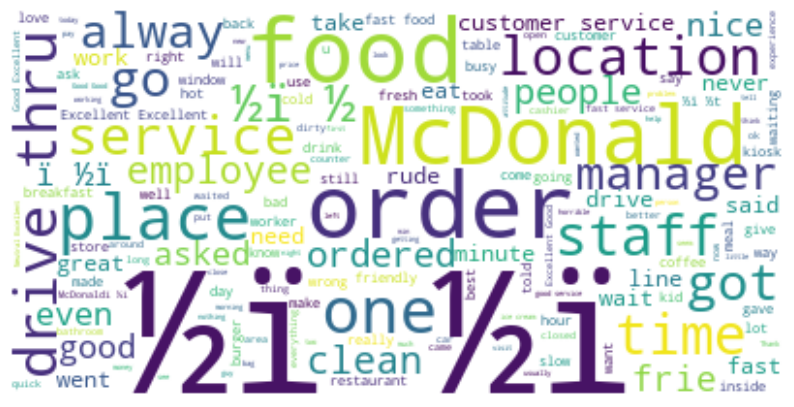

In [150]:
# Une todas las reseñas en una sola cadena de texto
long_string = ','.join(list(df['review'].values))

# Crea un objeto WordCloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)# Genera la nube de palabras a partir de la cadena de texto

# Muestra la nube de palabras
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [151]:
#verificar columnas
df.columns

Index(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')

In [152]:
# Crear un DataFrame de ejemplo
#data = {'review': ['Buen servicio y comida deliciosa.', 'La comida estaba fría y el lugar sucio.',
                   #'Me encantan sus papas fritas.', 'El personal es lento, mala experiencia.',
                   #'Todo perfecto, volveré pronto.', 'Nunca más volveré, horrible lugar.',
                   #'El café estaba bien, pero la fila era muy larga.', 'Me gustó el ambiente.',
                   #'El servicio es lento.', 'Una experiencia terrible.', 'Muy buen restaurante.'],
        #'rating': [5, 1, 5, 2, 4, 1, 3, 4, 2, 1, 5]}
#df = pd.DataFrame(data)

In [153]:
#Verificar los valores nulos con la función null_count()
def null_count(df_to_check):
    return pd.DataFrame({'features': df_to_check.columns,
                         'dtypes': df_to_check.dtypes.values,
                         'NaN count': df_to_check.isnull().sum().values,
                         'NaN percentage': df_to_check.isnull().sum().values / df_to_check.shape[0]}).style.background_gradient(cmap='turbo', low=0.1, high=0.01)

print("Resumen de valores nulos:")
display(null_count(df))


Resumen de valores nulos:


,features,dtypes,NaN count,NaN percentage
0,reviewer_id,int64,0,0.000000
1,store_name,object,0,0.000000
2,category,object,0,0.000000
3,store_address,object,0,0.000000
4,latitude,float64,660,0.019763
5,longitude,float64,660,0.019763
6,rating_count,object,0,0.000000
7,review_time,object,0,0.000000
8,review,object,0,0.000000
9,rating,object,0,0.000000


In [154]:
df.duplicated().sum()

np.int64(0)

In [155]:
#Calcular los valores no nulos por columna
non_null_counts = df.count()

<Axes: >

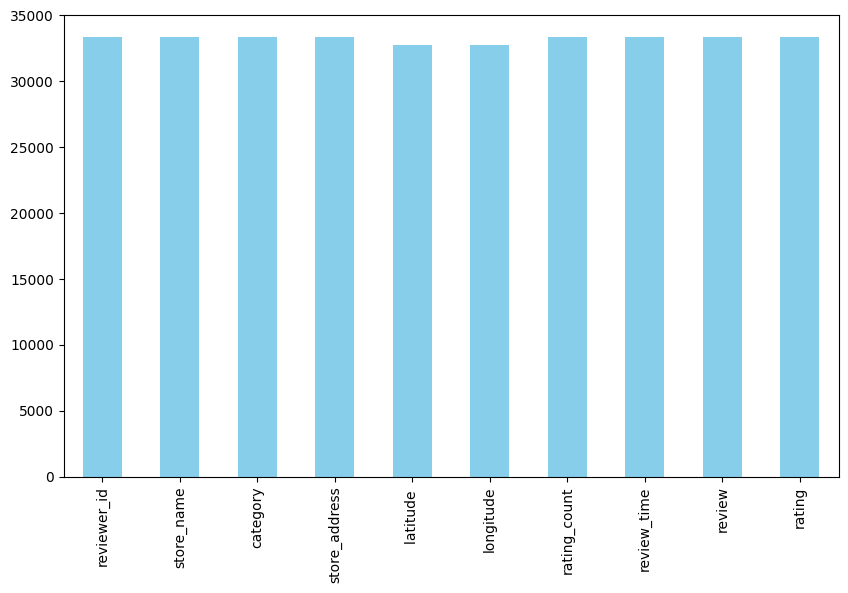

In [156]:
#Crear el gráfico de barras
plt.figure(figsize=(10, 6)) # Define el tamaño del gráfico
non_null_counts.plot(kind='bar', color='skyblue') # Usa el método de plot de Pandas#

In [157]:
#Eliminar filas con valores nulos en 'review' y 'rating' y asignación de sentimientos
# Limpieza de datos y asignación de sentimientos

# Continúa con la limpieza
df.dropna(subset=['review', 'rating'], inplace=True)
def extract_single_rating(rating):
    if pd.isna(rating):
        return np.nan
    rating_str = str(rating)
    # Extrae el primer dígito encontrado en la cadena
    digits = [char for char in rating_str if char.isdigit()]
    if digits:
        return float(digits[0])
    return np.nan

    
# Aplica la nueva función a la columna 'rating'
df['rating'] = df['rating'].apply(extract_single_rating)


# Clasificación de NPS
df.dropna(subset=['review', 'rating'], inplace=True)
df['sentiment'] = df['rating'].apply(lambda x: 'positivo' if x >= 4 else ('neutral' if x == 3 else 'negativo'))

# Definir las variables X e y
X = df['review'].values
y = df['sentiment'].values
print("\nDatos listos para el preprocesamiento.")



Datos listos para el preprocesamiento.


In [158]:
# División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTamaño del conjunto de entrenamiento: {len(X_train)}")


Tamaño del conjunto de entrenamiento: 26716


Preprocesamiento de texto para Deep Learning

In [159]:
MAX_FEATS = 15000  # Número de palabras más comunes a considerar


In [160]:
# Tokenización de texto
#tokenizer = Tokenizer(num_words=MAX_FEATS)
#tokenizer.fit_on_texts(X_train)

#X_train_sequences = tokenizer.texts_to_sequences(X_train) # Convertir texto a secuencias de números
#X_test_sequences = tokenizer.texts_to_sequences(X_test)

#Convertir texto en numero
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATS, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)




In [161]:
# Visualización de la distribución de clases balance inicial
print(f"Distribución original de las clases: {Counter(y_train)}")

Distribución original de las clases: Counter({'positivo': 12863, 'negativo': 9974, 'neutral': 3879})


In [162]:
# Aplicar SMOTE para balancear las clases  los datos numéricos
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)



In [163]:
# imprimir la distribución de clases después del balanceo
print(f"Distribución de clases después del balanceo: {Counter(y_train_resampled)}")

Distribución de clases después del balanceo: Counter({'neutral': 12863, 'positivo': 12863, 'negativo': 12863})


In [164]:
# Convertir las matrices dispersas a densas
X_train_resampled_dense = X_train_resampled.toarray()
X_test_dense = X_test_tfidf.toarray()


In [165]:
# Padding de  secuencias con la misma longitud
#max_sequence_len = max([len(x) for x in X_train_sequences])
#X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_len, padding='post')
#X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_len, padding='post')



modelo de Deep Learning (con capas DENSE)

In [166]:
#Construcción y entrenamiento del modelo
num_features = X_train_resampled_dense.shape[1]

"""model = Sequential()
model.add(Dense(1024, input_dim=num_features, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))"""

"""model = Sequential()
model.add(Dense(1024, input_dim=num_features))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(len(np.unique(y)), activation='softmax'))"""

model = Sequential()
model.add(Dense(1024, input_dim=num_features))
model.add(PReLU())  # Usamos PReLU aquí
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(PReLU())  # Y aquí también
model.add(Dense(256))
model.add(PReLU())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(PReLU())
"""model.add(Dropout(0.5))
model.add(Dense(64))
model.add(PReLU())"""
model.add(Dense(len(np.unique(y)), activation='softmax'))

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [167]:
"""model = Sequential()
model.add(Embedding(input_dim=MAX_FEATS + 1, output_dim=128, input_length=max_sequence_len)) ## Capa de Embedding: Mapea los índices de enteros a vectores densos.
model.add(LSTM(128)) # Capa LSTM: Captura dependencias a largo plazo en secuencias.
model.add(Dropout(0.5)) # Capa Dropout: Previene el sobreajuste.
model.add(Dense(64, activation='relu')) # capa oculta con 64 neuronas
model.add(Dense(32, activation='relu')) # capa oculta con 32 neuronas
model.add(Dense(num_classes, activation='softmax')) # capa de salida

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()"""

"""inputs = Input(shape=(max_sequence_len,))
embedding_layer = Embedding(input_dim=MAX_FEATS + 1, output_dim=128)(inputs) # capa de embedding
lstm_out = LSTM(128, return_sequences=True)(embedding_layer) # capa LSTM
attention_out = Attention()([lstm_out, lstm_out]) #capa de atención
attention_out = tf.keras.layers.GlobalAveragePooling1D()(attention_out) # alimentar la capa densa

dense1 = Dense(64, activation='relu')(attention_out) #capa oculta con 64 neuronas
dropout = Dropout(0.5)(dense1) #capa de dropout
dense2 = Dense(32, activation='relu')(dropout) #capa oculta con 32 neuronas
outputs = Dense(num_classes, activation='softmax')(dense2) #capa de salida

model = Model(inputs=inputs, outputs=outputs) # Crear el modelo"""






"inputs = Input(shape=(max_sequence_len,))\nembedding_layer = Embedding(input_dim=MAX_FEATS + 1, output_dim=128)(inputs) # capa de embedding\nlstm_out = LSTM(128, return_sequences=True)(embedding_layer) # capa LSTM\nattention_out = Attention()([lstm_out, lstm_out]) #capa de atención\nattention_out = tf.keras.layers.GlobalAveragePooling1D()(attention_out) # alimentar la capa densa\n\ndense1 = Dense(64, activation='relu')(attention_out) #capa oculta con 64 neuronas\ndropout = Dropout(0.5)(dense1) #capa de dropout\ndense2 = Dense(32, activation='relu')(dropout) #capa oculta con 32 neuronas\noutputs = Dense(num_classes, activation='softmax')(dense2) #capa de salida\n\nmodel = Model(inputs=inputs, outputs=outputs) # Crear el modelo"

In [168]:
#Entrenar el modelo

model.summary()




Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 1024)           │    13,192,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_12 (PReLU)              │ (None, 1024)           │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_13 (PReLU)              │ (None, 512)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_14 (PReLU)              │ (None, 256)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_15 (PReLU)              │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,883,523 (52.96 MB)

 Trainable params: 13,883,523 (52.96 MB)

 Non-trainable params: 0 (0.00 B)

In [169]:
"""#Convertir las etiquetas de entrenamiento a formato numérico
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train_resampled)
y_test_encoded = lb.transform(y_test)
num_classes = len(lb.classes_)"""


'#Convertir las etiquetas de entrenamiento a formato numérico\nlb = LabelBinarizer()\ny_train_encoded = lb.fit_transform(y_train_resampled)\ny_test_encoded = lb.transform(y_test)\nnum_classes = len(lb.classes_)'

In [170]:
#Convertir las etiquetas de entrenamiento a formato numérico
y_train_resampled_fixed = y_train_resampled.ravel()
y_test_fixed = y_test.ravel()

#Usar LabelEncoder para evitar el error de 3 dimensione
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train_resampled_fixed)
y_test_encoded = le.transform(y_test_fixed)




# Convertir a formato para que el modelo lo entienda
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes=len(le.classes_))
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes=len(le.classes_))

#compilar el modelo
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])




In [171]:
print("\n--- Verificación de formas de los arrays ---")
print(f"Forma de X_train_resampled (despuÃ©s de SMOTE): {X_train_resampled.shape}")
print(f"Forma de y_train_resampled (despuÃ©s de SMOTE): {y_train_resampled.shape}")
print("-" * 30)



--- Verificación de formas de los arrays ---
Forma de X_train_resampled (despuÃ©s de SMOTE): (38589, 12882)
Forma de y_train_resampled (despuÃ©s de SMOTE): (38589,)
------------------------------


In [172]:
history = model.fit(X_train_resampled_dense, y_train_categorical,
          epochs=20,
          batch_size=32,
          validation_data=(X_test_dense, y_test_categorical),
          verbose=1)


Epoch 1/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.4946 - loss: 1.0654 - val_accuracy: 0.4476 - val_loss: 0.9926
Epoch 2/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.6075 - loss: 0.8839 - val_accuracy: 0.7524 - val_loss: 0.7052
Epoch 3/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.6931 - loss: 0.7170 - val_accuracy: 0.7579 - val_loss: 0.6036
Epoch 4/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7395 - loss: 0.6322 - val_accuracy: 0.7804 - val_loss: 0.5532
Epoch 5/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7592 - loss: 0.5876 - val_accuracy: 0.7501 - val_loss: 0.6232
Epoch 6/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7787 - loss: 0.5533 - val_accuracy: 0.7813 - val_loss: 0.5564
Epoch 7/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7928 - loss: 0.5220 - val_accuracy: 0.7454 - val_loss: 0.6419
Epoch 8/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.8084 -

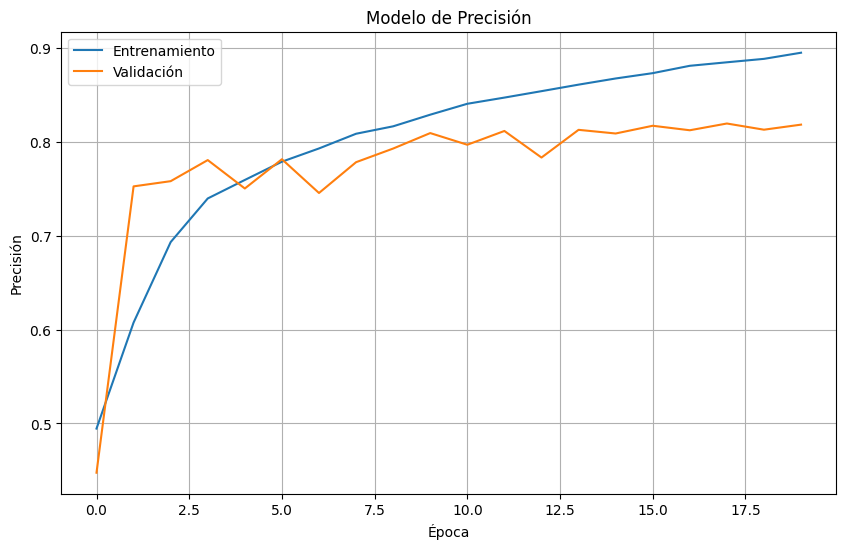

In [173]:
# Extrae los datos de accuaracy y val_accuracy del historial
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo de Precisión')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.grid(True)
plt.show()

In [174]:
#Evaluar el modelo ---
loss, accuracy = model.evaluate(X_test_dense, y_test_categorical, verbose=0)
print(f"\nPrecisión en el conjunto de prueba: {accuracy:.4f}")


Precisión en el conjunto de prueba: 0.8181


In [175]:
#Ejemplo de predicción
new_review_es = "la carne sabrosa pero las papas horribles."
translator = GoogleTranslator(source='spanish', target='english')
new_review_en = translator.translate(new_review_es)

print(f"\nReseña original en español: '{new_review_es}'")
print(f"Reseña traducida al inglés: '{new_review_en}'")

new_review_tfidf = tfidf_vectorizer.transform([new_review_en])
prediction = model.predict(new_review_tfidf.toarray())
predicted_class_index = np.argmax(prediction)
predicted_sentiment = le.inverse_transform([predicted_class_index])
print(f"\nPredicción del sentimiento: {predicted_sentiment[0]}")
#print(f"\nPredicción del NPS: {prediction[0]}")


Reseña original en español: 'la carne sabrosa pero las papas horribles.'
Reseña traducida al inglés: 'Tasty meat but horrible potatoes.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Predicción del sentimiento: negativo
